# Assignment 1: 2D radioactive lighthouse location using MCMC

As before, a radioactive source that emits gamma rays randomly in time but uniformly in angle is placed at $(x_0, y_0)$.  The gamma rays are detected on the $x$-axis and these positions are saved, $x_k$, $k=1,2,\cdots, N$.  Given these observed positions, the problem is to estimate the location of the source.

Unlike before, we will not assume that $y_0$ is known. Your task is to estimate both $x_0$ and $y_0$.  Since we are using Bayesian methods, this means finding the joint posterior for $x_0$ and $y_0$, given the data on where the gamma rays were detected.

You will combine the results and Python code from the `radioactive_lighthouse_exercise.ipynb` and `parameter_estimation_Gaussian_noise.ipynb` notebooks, sampling the posterior using `emcee` and plotting it using `corner`.


## Expressions

The posterior we want is:

$$ p(x_0, y_0 | \{x_k\}, I) = \frac{p(\{x_k\}|x_0,y_0,I)p(x_0,y_0|I)}{p(\{x_k\}|I)}
$$

*Using $\LaTeX$, fill in the right side of the equation for Bayes' rule as it applies in this case.* 


*Then add below the expression for the likelihood in this case (replace the dots with the correct form and fill in the right side):*

$$  p(\{x_k\},I | x_0,y_0) = \prod_{k=1}^{N} p(x_k|x_0,y_0),
$$
where
$$ {p(x_k|x_0, y_0) = \frac{y_0}{\pi} \frac{1}{y_0^2 + (x_k - x_0)^2}} \; $$



*Describe in words what you will use for the prior:*

Since $x_0$ and $y_0$ are independent, then we can express the prior as:

$$ p(x_0,y_0|I) = p(x_0|I)p(y_0|I)$$

We'll use the same prior as in the 1D exercise, since we can assume that the source is not located very far from the detector in $x$. For $y$, we can't say that, but we'll assume that it's bounded for computational purposes. Then,


$$p(x_0 | y_0) = p(x_0)p(y_0) = \frac{1}{|x_{max} - x_{min}|} \frac{1}{|y_{max} - y_{min}|} \quad\mbox{for}\ x_{min} < x_0 < x_{max} $$

*Do you need to find an expression for the denominator pdf?  Explain.*

The denominator will be an overall constant, since it's independent of $x_0$ and $y_0$, this means that we don't need to find an expression for the denominator as we can normalize at the end.

## Python imports

You will need to import emcee and corner.  The best way to do this is to follow the instructions for making an environment (see Carmen page).  An alternative is to install them separately using (at the command line):

`conda install -c astropy emcee`

`conda install -c astropy corner`

In [1]:
%matplotlib inline   

import numpy as np

import scipy.stats as stats
from scipy.stats import cauchy, uniform

import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # for plot formatting
import emcee
import corner


## Generating the data

Copy-and-paste here the code from `radioactive_lighthouse_exercise.ipynb` used to generate the $x_k$ points.  Note that you have control over where the true position is but also the size of the dataset.  You will want to adjust both later. It is recommended to add the code that plots the distribution of the data (to verify it is the same as before), but this is not required.

maximum =  2590.055410489386
minimum =  -1173.1741128243862


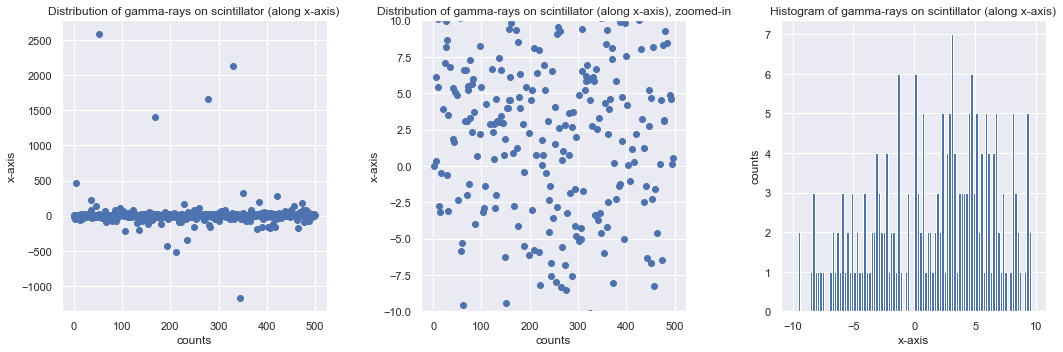

In [6]:
# Add code here to generate the dataset.  Start with 500 points.
# True location of the radioactive source
x0_true = 3.5
y0_true = 10

# Generate num_pts random numbers distributed according to dist and plot 
num_pts = 500
x_pts = np.arange(num_pts)

# Distribution knowing where the source is: scipy.stats.cauchy(loc, scale)
dist = cauchy(x0_true, y0_true)
dist_pts = dist.rvs(num_pts)  

# Make some plots!
fig = plt.figure(figsize=(15,5))

# First plot all the points, letting it autoscale the counts
ax_1 = fig.add_subplot(1,3,1)
ax_1.scatter(x_pts, dist_pts)  
ax_1.set_title("Distribution of gamma-rays on scintillator (along x-axis)")
ax_1.set_xlabel("counts")
ax_1.set_ylabel("x-axis")

# Repeat but zoom in to near the origin
ax_2 = fig.add_subplot(1,3,2)
ax_2.scatter(x_pts, dist_pts)
ax_2.set_ylim(-10.,10.)
ax_2.set_title("Distribution of gamma-rays on scintillator (along x-axis), zoomed-in")
ax_2.set_xlabel("counts")
ax_2.set_ylabel("x-axis")

# Finally make a zoomed-in histogram
ax_3 = fig.add_subplot(1,3,3)
out = ax_3.hist(dist_pts, bins=np.arange(-10., 10., 0.2))
ax_3.set_title("Histogram of gamma-rays on scintillator (along x-axis)")
ax_3.set_ylabel("counts")
ax_3.set_xlabel("x-axis")

# Print out the numerical limits (max and min)
print('maximum = ', np.amax(dist_pts))
print('minimum = ', np.amin(dist_pts))

fig.tight_layout()

## PDFs for applying Bayes' rule

*Adapt code from the two notebooks to express the logarithms of the prior, likelihood, and posterior for this case.*

We define ${\bf \theta}$ to be a 2-D vector whose elements are $x_0$ and $y_0$, i.e.
$$ {\bf \theta}=(x_0,y_0) $$

In [7]:
# Add code for the log_prior, log_likelihood, and log_posterior

min_theta=np.array([-20,0]) #let x,y be greater than -4, following 1D lighthouse example.
max_theta=np.array([20,4]) ##let x,y be less than 4, following 1D lighthouse example.
#volume_theta=np.prod(abs(max_theta-min_theta)) #c.f. our choice for the prior
volume_theta=abs(max_theta[0]-min_theta[0])*abs(max_theta[1]-min_theta[1])
def log_prior(theta):
    '''Log prior for parameter array theta'''
    assert len(theta)==2, "Parameter vector must have length two."
    # flat prior 
    if np.logical_and(min_theta<=theta, theta<=max_theta).all(): 
        return np.log(1/volume_theta)
    else:
        return -np.inf  
    
def log_likelihood(theta, X): 
    '''Log likelihood for data X given parameter array theta'''
    if theta[1]<0:
        return -np.inf
    try:
        return np.sum( -np.log(theta[1]**2 + (X - theta[0])**2) )\
                        +len(X)*np.log(theta[1]/np.pi)
    except ValueError:
        return -np.inf
    
def log_posterior(theta,  X):
    '''Log posterior for data X given parameter array theta'''
    return log_prior(theta) + log_likelihood(theta, X)

## Run MCMC

*Copy code to run `emcee` and make any necessary changes.*

In [8]:
# Add the code to run emcee
ndim = 2  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 1000  # number of MCMC steps to take

# we'll start at random locations within the prior volume
starting_guesses = min_theta + \
                   (max_theta - min_theta) * np.random.rand(nwalkers,ndim)

print("MCMC sampling using emcee (affine-invariant ensamble sampler) with {0} walkers".format(nwalkers))
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[dist_pts])

# "burn-in" period; save final positions and then reset
pos, prob, state = sampler.run_mcmc(starting_guesses, nburn)
sampler.reset()

# sampling period
sampler.run_mcmc(pos, nsteps)

print("Mean acceptance fraction: {0:.3f} (in total {1} steps)"
                .format(np.mean(sampler.acceptance_fraction),nwalkers*nsteps))

# discard burn-in points and flatten the walkers; the shape of samples is (nwalkers*nsteps, ndim)
samples = sampler.chain.reshape((-1, ndim))

MCMC sampling using emcee (affine-invariant ensamble sampler) with 50 walkers
Mean acceptance fraction: 0.667 (in total 50000 steps)


## Generate figures

Note: you do not need to do the maximum likelihood estimates that were added to the corner plot for the Gaussian noise case.  You can skip that part of the code.

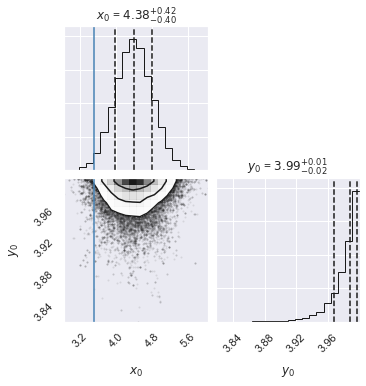

In [9]:
# Add the code to make a corner plot
# make a corner plot with the posterior distribution
fig = corner.corner(samples, labels=["$x_0$", "$y_0$"],
                      truths=[x0_true, y0_true],quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})

## Analysis

Summarize the results for the following investigations.  You can simply add to the cell containing the question or else start new cells.

1. *Run the notebook 10 times (which will generate 10 different sets of random data).  Record the values of $x_0$ and $y_0$ and their uncertainties given on the corner plot for each run.  Is the actual spread of values consistent with the given uncertainties?*

|     Trial     | $x_0$ | $y_0$ |
| :-------------: | :----------: | :----------: 
| 
|  1         |   $1.05^{+0.06}_{-0.06}$     |    $1.00^{+0.06}_{-0.06}$  |
|  2         |     $0.98^{+0.06}_{-0.06}$   |   $0.94^{+0.06}_{-0.06}$  |
|  3         |   $0.97^{+0.06}_{-0.06}$     |    $1.05^{+0.07}_{-0.06}$ |
|  4         |   $0.94^{+0.06}_{-0.06}$     |    $0.95^{+0.06}_{-0.06}$ |
|  5         |   $0.96^{+0.06}_{-0.06}$    |    $1.01^{+0.07}_{-0.06}$ |
|  6         |   $0.93^{+0.06}_{-0.06}$     |    $1.00^{+0.06}_{-0.06}$ |
|  7         |   $0.99^{+0.07}_{-0.08}$     |    $1.13^{+0.07}_{-0.07}$ |
|  8         |   $1.01^{+0.06}_{-0.06}$     |    $0.89^{+0.06}_{-0.06}$ |
|  9         |   $0.95^{+0.06}_{-0.06}$    |    $1.01^{+0.06}_{-0.06}$ |
|  10         |  $1.08^{+0.07}_{-0.07}$    |    $1.01^{+0.06}_{-0.06}$ |


The uncertainties correspond to 1$\sigma$ deviation (68\%), meaning that the probability of finding the true value within that range is of about 68\%. This agrees with the observation that 8 of the $x_0$ we got are within the range of the true value, and 8 of the $y_0$ values are within the range.

2. *Increase the number of data points by a factor of 10.  By how much does the width of the posterior shrink?  Is this expected?*

It shrinks by a factor of $\sim 3$. This is expected, since the width of the distribution goes as $1/\sqrt{N}$, and $\sqrt{10}\sim 3$

3. *What does increasing the number of MC steps per walker do?*

They smooth out the distributions by increasing the sampling of the posterior. The distributions look more gaussian as the steps increase

4. *Try changing `x0_true` and `y0_true`.  Does it still work?*